In [34]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')

pd.set_option('display.max_colwidth', 300)

# Read data
df = pd.read_pickle('Data/MovieSummaries/plots_genres_balanced.pkl')
df_train = pd.read_pickle('Data/MovieSummaries/train_plots_genres_balanced.pkl')
df_test = pd.read_pickle('Data/MovieSummaries/test_plots_genres_balanced.pkl')

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
#Dataset overview
df.reset_index(inplace=True)
df.head()

df_train.reset_index(inplace=True)
df_train.head()

df_test.reset_index(inplace=True)
df_test.head()

,index,id,text,title,genre
0,14805,5016784,joe is the son of famous opera singer caterina silveri while joe believes that caterinas husband douglas winter is his biological father the truth is that he was sired by caterinas former lover who is now living in italy and working as a schoolteacher joe is moody and rebellious and needs a stro...,La Luna,"[drama, war]"
1,15143,27880897,the film is a reversal of the dr jekyll and mr hyde story about a malformed doctor who drinks a potion and becomes a handsome ladies man,Dr. Heckyl and Mr. Hype,"[parody, comedy]"
2,13662,28214407,oliver watson has never been luckier he is a successful advertising executive shares a marriage of eighteen years with sarah and has three loving kids yearold ben yearold melissa and yearold sam his perfect life suddenly falls apart when his wife sarah announces that she wants to enter a graduat...,Daddy,"[drama, romance, adaptation, television]"
3,5498,461657,featuring concert footage of legendary los angeles punk bands and interviews both with band members the publishers of slash fanzine and with the punks who made up their audience the film offers a look into a subculture that was largely ignored by the rock music press of the time the promotional ...,The Decline of Western Civilization,"[biography, music, documentary]"
4,7433,1686031,bart is a vicious loan shark whose method of persuading men to pay him back involves danny the dog a man with the mentality of a child only if a metal collar around his neck is removed by bart will he become a violently skilled fighter who stops at nothing to take down his targets but once the c...,Unleashed,"[thriller, crime, actionadventure, martial arts, coming of age, drama, action]"


In [36]:
#clean text
df["text"] = df["text"].apply(lambda x : clean_text(x))
df_train["text"] = df_train["text"].apply(lambda x : clean_text(x))
df_test["text"] = df_test["text"].apply(lambda x : clean_text(x))

# Get stopwords
#if stopwords not downloaded
#
stopwords = set(stopwords.words("english"))
df["text"] = df["text"].apply(lambda x : remove_stopwords(x))
df_train["text"] = df_train["text"].apply(lambda x : remove_stopwords(x))
df_test["text"] = df_test["text"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(df["genre"])

ytrain = multilabel_bina.transform(df_train["genre"])
yval = multilabel_bina.transform(df_test["genre"])
xtrain = df_train["text"]
xval = df_test["text"]

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)

xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [37]:
#make list aff all genre
genre_list = []
for i in range(len(df["genre"])):
    genre_list.append(df["genre"].iloc[i][0])

#unique genre
unique_genre = list(set(genre_list))
len(unique_genre)

57

In [38]:
# Documents Example with 5 Plots
documents = df["text"][0:5].reset_index(drop=True)

# Term Frequency-Inverse Document Frequency vectorizer
Tfid_vect = TfidfVectorizer()

# Transform the documents using the vectorizer
documents_vect = Tfid_vect.fit_transform(documents)


# Multi label logistic Regression

In [39]:

# Logistic Regression
logistic_mod = LogisticRegression()

# Separate binary classifier for each class label for multi-label classification
onevsall = OneVsRestClassifier(logistic_mod) 

# Train model
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



              precision    recall  f1-score   support

           0       0.79      0.33      0.47       616
           1       0.73      0.21      0.32       477
           2       1.00      0.00      0.01       238
           3       0.82      0.24      0.36       417
           4       0.93      0.25      0.39       271
           5       1.00      0.01      0.02       128
           6       1.00      0.05      0.09       171
           7       1.00      0.06      0.10       217
           8       1.00      0.01      0.01       150
           9       0.97      0.09      0.17       417
          10       1.00      0.01      0.02       131
          11       0.70      0.15      0.25       126
          12       0.88      0.10      0.18       153
          13       0.87      0.08      0.14       169
          14       0.96      0.33      0.50       156
          15       0.80      0.47      0.59      1172
          16       0.00      0.00      0.00       221
          17       0.91    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_balanced_log_reg.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df_test['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df_test['genre'][k], "\n")

Movie:  The Open Road 
Predicted genre:  [('drama',)]
Actual genre:  ['comedydrama', 'comedy', 'indie'] 

Movie:  I'll Take Manhattan 
Predicted genre:  [('drama', 'romance')]
Actual genre:  ['melodrama', 'drama'] 

Movie:  Tully 
Predicted genre:  [('drama',)]
Actual genre:  ['drama', 'indie'] 

Movie:  Once Upon a Time in China 
Predicted genre:  [('action', 'actionadventure', 'chinese', 'martial arts', 'war')]
Actual genre:  ['martial arts', 'adventure', 'chinese'] 

Movie:  Ninja Assassin 
Predicted genre:  [('action', 'actionadventure', 'drama', 'thriller')]
Actual genre:  ['thriller', 'crime', 'actionadventure', 'martial arts', 'drama', 'action'] 



In [42]:
#Apply it to all Film
f = pd.DataFrame(xval)
f['generated_genre'] = pd.DataFrame(xval)['text'].apply(new_val)
f= f.merge(df_test, left_index=True, how='left', right_index=True).reset_index(drop=True)
f.head(10)

,text_x,generated_genre,index,id,text_y,title,genre
0,joe son famous opera singer caterina silveri joe believes caterinas husband douglas winter biological father truth sired caterinas former lover living italy working schoolteacher joe moody rebellious needs strong father figure guide keep line douglas ineffectual emotionally weak joe witnesses su...,"[(drama,)]",14805,5016784,joe son famous opera singer caterina silveri joe believes caterinas husband douglas winter biological father truth sired caterinas former lover living italy working schoolteacher joe moody rebellious needs strong father figure guide keep line douglas ineffectual emotionally weak joe witnesses su...,La Luna,"[drama, war]"
1,film reversal dr jekyll mr hyde story malformed doctor drinks potion becomes handsome ladies man,[()],15143,27880897,film reversal dr jekyll mr hyde story malformed doctor drinks potion becomes handsome ladies man,Dr. Heckyl and Mr. Hype,"[parody, comedy]"
2,oliver watson never luckier successful advertising executive shares marriage eighteen years sarah three loving kids yearold ben yearold melissa yearold sam perfect life suddenly falls apart wife sarah announces wants enter graduate school miles away home regrets gave bohemian protesters life pro...,"[(comedy, drama, romance)]",13662,28214407,oliver watson never luckier successful advertising executive shares marriage eighteen years sarah three loving kids yearold ben yearold melissa yearold sam perfect life suddenly falls apart wife sarah announces wants enter graduate school miles away home regrets gave bohemian protesters life pro...,Daddy,"[drama, romance, adaptation, television]"
3,featuring concert footage legendary los angeles punk bands interviews band members publishers slash fanzine punks made audience film offers look subculture largely ignored rock music press time promotional poster decline featured closeup frame germs singer darby crash supine stage eyes closed cr...,"[(documentary, music)]",5498,461657,featuring concert footage legendary los angeles punk bands interviews band members publishers slash fanzine punks made audience film offers look subculture largely ignored rock music press time promotional poster decline featured closeup frame germs singer darby crash supine stage eyes closed cr...,The Decline of Western Civilization,"[biography, music, documentary]"
4,bart vicious loan shark whose method persuading men pay back involves danny dog man mentality child metal collar around neck removed bart become violently skilled fighter stops nothing take targets collar danny harmless withdrawn person little knowledge live socialized person constantly bullied ...,[()],7433,1686031,bart vicious loan shark whose method persuading men pay back involves danny dog man mentality child metal collar around neck removed bart become violently skilled fighter stops nothing take targets collar danny harmless withdrawn person little knowledge live socialized person constantly bullied ...,Unleashed,"[thriller, crime, actionadventure, martial arts, coming of age, drama, action]"
5,shlomo ethiopian boy placed christian mother ethiopian jewish woman whose child died woman become adoptive mother airlifted sudanese refugee camp israel operation moses birth mother hopes better life tells go live become leaves board plane film tells growing israel deals secrets carries jewish l...,"[(drama,)]",18802,7115730,shlomo ethiopian boy placed christian mother ethiopian jewish woman whose child died woman become adoptive mother airlifted sudanese refugee camp israel operation moses birth mother hopes better life tells go live become leaves board plane film tells growing israel deals secrets carries jewish l...,"Go, See, and Become","[drama, political]"
6,taj badalandabad personal assistant legendary van wilder graduated coolidge college way englands camford university taj plans follow footsteps father obtaining degree also become member exclusive campus fraternal guild fox hounds taj hopes become n

## Multilabel classification confusion matrix with MLCM Paper function

In [43]:

#clean lists
for i in range(len(f["generated_genre"])):
    f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]

#sort lists in genre alphabetically
f["genre"] = f["genre"].apply(lambda x: sorted(x))


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_18460\2050906492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]


### MLCM Library with minor changes in code

c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:205: RuntimeWarning: invalid value encountered in divide
  precision = tp/(tp+fp)
c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:208: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)



       class#     precision        recall      f1-score        weight

            0          0.59          0.31          0.41          657
            1          0.49          0.20          0.28          491
            2          1.00          0.00          0.01          242
            3          0.64          0.23          0.33          435
            4          0.91          0.23          0.36          294
            5          1.00          0.01          0.01          138
            6          1.00          0.05          0.09          173
            7          1.00          0.05          0.10          221
            8          1.00          0.01          0.01          150
            9          0.95          0.09          0.16          437
            10          1.00          0.01          0.02          132
            11          0.58          0.13          0.21          145
            12          0.62          0.10          0.17          156
            13          0.72

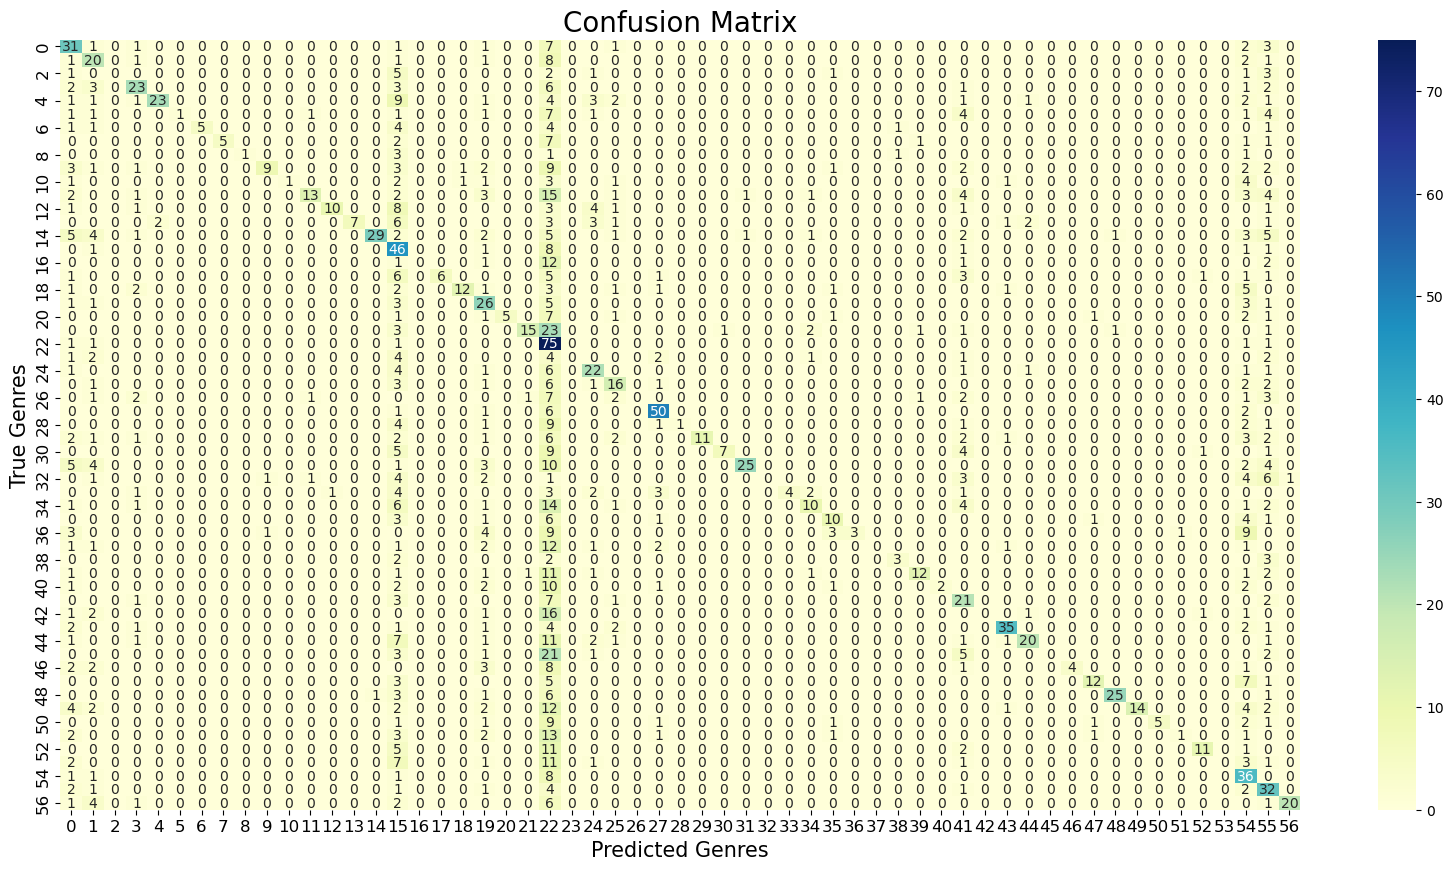

In [45]:
#Numpy Version problems solved
from mlcm_changed import mlcm

conf_mat,normal_conf_mat = mlcm.cm(yval,y_pred,False)
one_vs_rest = mlcm.stats(conf_mat,False)

#make dataframe from confusion matrix
df_confusion = pd.DataFrame(normal_conf_mat)
#drop last column
df_confusion = df_confusion.iloc[:-1,:-1]


#plot df_confusion
plt.figure(figsize = (20,10))
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Genres', fontsize=15)
plt.ylabel('True Genres', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Rest vs All plots

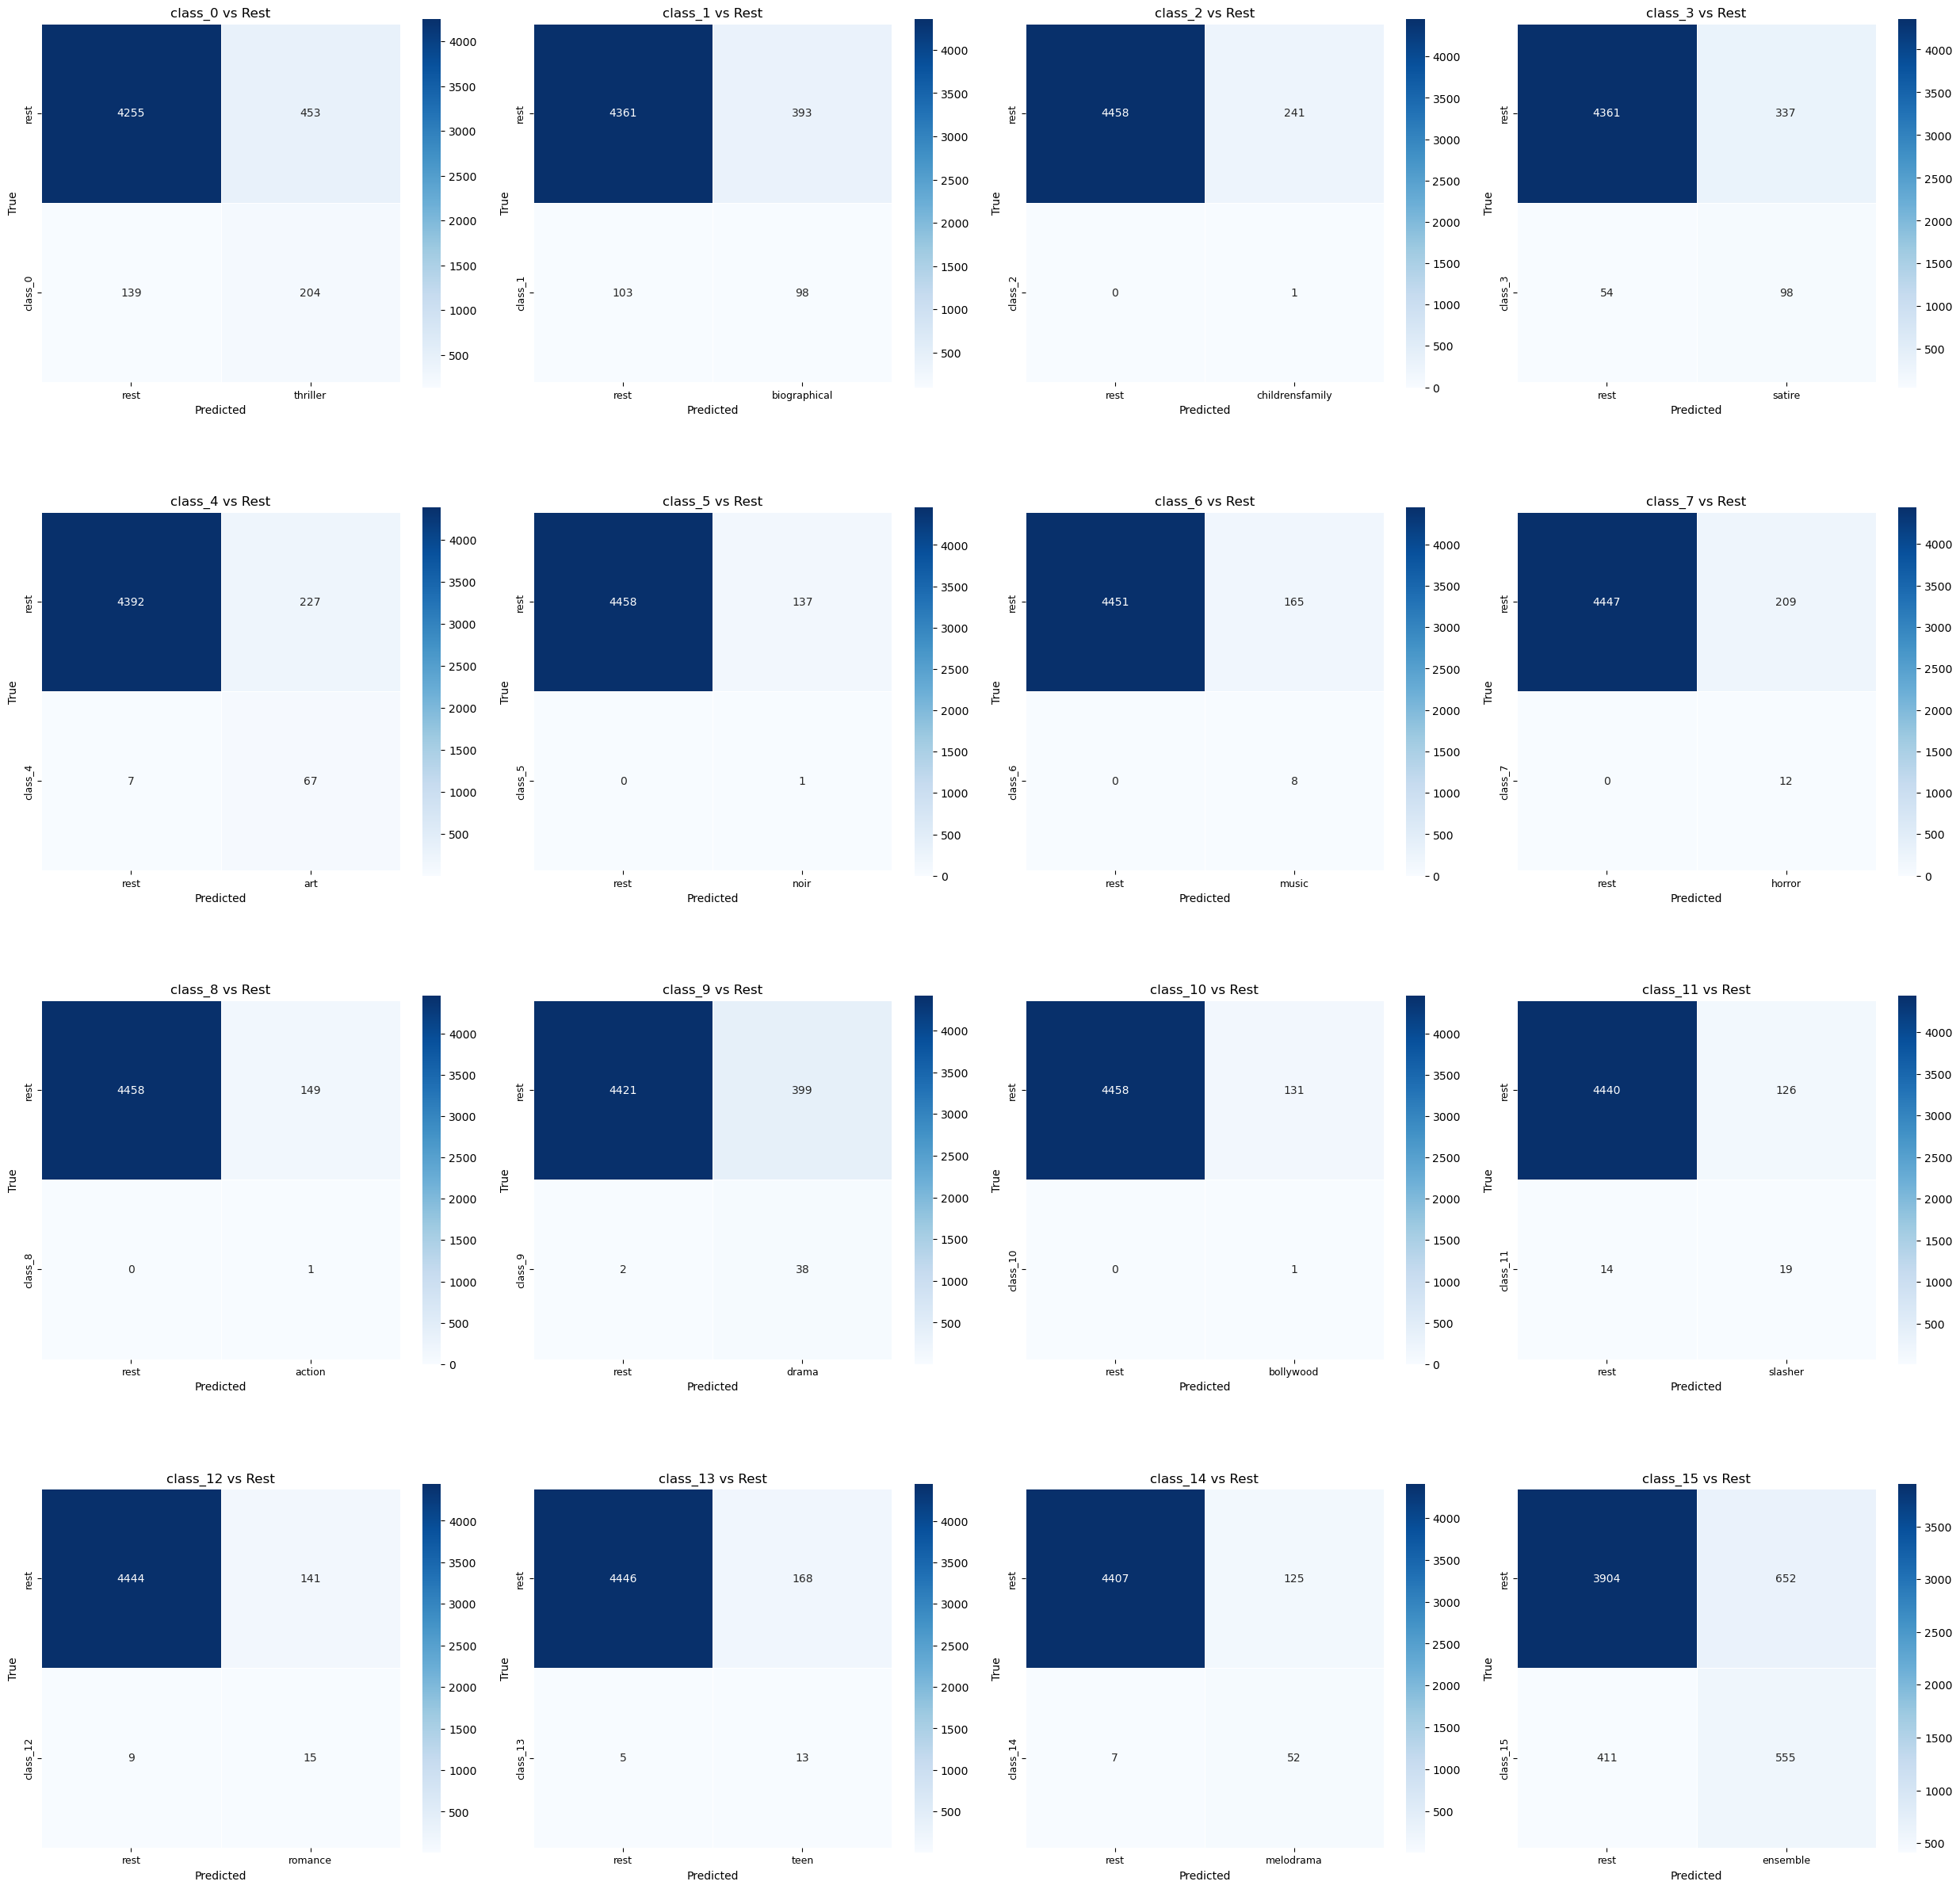

In [46]:

plt.figure(figsize=(25, 25))


n=16
#  first n
for i in range(n):  
    #column names
    colnames = ['rest', f'class_{i}']
    
    #DataFrame
    df1 = pd.DataFrame(one_vs_rest[i], columns=colnames, index=['rest' , unique_genre[i]]).transpose()

    ax = plt.subplot(int(n/4), 4, i + 1)
    
    #heatmap
    sns.heatmap(df1, annot=True, fmt="d", cmap="Blues", square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Titles and labels
    ax.set_title(f'class_{i} vs Rest', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()


### Naive Bayes

In [47]:
# do with naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(GaussianNB())

# Train the classifier on the training set
classifier.fit(xtrain_tfidf.toarray(), ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf.toarray())
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec.toarray())
    return multilabel_bina.inverse_transform(x_pred)

              precision    recall  f1-score   support

           0       0.33      0.73      0.45       616
           1       0.27      0.69      0.39       477
           2       0.18      0.64      0.28       238
           3       0.26      0.66      0.38       417
           4       0.38      0.64      0.48       271
           5       0.40      0.53      0.46       128
           6       0.32      0.77      0.46       171
           7       0.36      0.75      0.48       217
           8       0.42      0.78      0.55       150
           9       0.28      0.68      0.40       417
          10       0.61      0.72      0.66       131
          11       0.34      0.40      0.37       126
          12       0.43      0.71      0.53       153
          13       0.38      0.64      0.48       169
          14       0.33      0.54      0.41       156
          15       0.44      0.83      0.58      1172
          16       0.22      0.51      0.31       221
          17       0.32    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df_test['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df_test['genre'][k], "\n")

Movie:  The Main Event 
Predicted genre:  [('blackandwhite', 'comedy', 'crime', 'drama', 'indie', 'romance', 'thriller', 'war')]
Actual genre:  ['comedy', 'sports', 'musical', 'romance'] 

Movie:  Michael Collins 
Predicted genre:  [('actionadventure', 'biographical', 'biography', 'biopic feature', 'blackandwhite', 'crime', 'drama', 'political', 'romance', 'thriller', 'war')]
Actual genre:  ['biography', 'political', 'biopic feature', 'drama', 'war', 'biographical'] 

Movie:  Surf II 
Predicted genre:  [('comedy', 'parody')]
Actual genre:  ['parody', 'indie', 'comedy', 'music'] 

Movie:  Super Troopers 
Predicted genre:  [('comedy',)]
Actual genre:  ['crime', 'mystery', 'comedy', 'slapstick'] 

Movie:  Jefferson in Paris 
Predicted genre:  [('biography', 'comedy', 'drama', 'indie', 'period piece')]
Actual genre:  ['biography', 'drama', 'period piece', 'romance', 'political'] 



In [49]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_balanced_NB.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df_test['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df_test['genre'][k], "\n")

Movie:  The Valley of Gwangi 
Predicted genre:  [('actionadventure', 'bmovie', 'comedy', 'family', 'fantasy', 'horror', 'western')]
Actual genre:  ['horror', 'actionadventure', 'western', 'fantasy', 'bmovie'] 

Movie:  Snow White 
Predicted genre:  [('comedy',)]
Actual genre:  ['drama', 'family', 'fantasy', 'television'] 

Movie:  FESTED: A Journey to Fest 7 
Predicted genre:  [('indie', 'parody', 'romance')]
Actual genre:  ['music', 'documentary'] 

Movie:  Hour of the Wolf 
Predicted genre:  [()]
Actual genre:  ['thriller', 'horror', 'art', 'war', 'supernatural', 'blackandwhite', 'drama'] 

Movie:  The Broken Land 
Predicted genre:  [('action', 'actionadventure', 'adaptation', 'adventure', 'animation', 'blackandwhite', 'bmovie', 'crime', 'family', 'fantasy', 'horror', 'indie', 'martial arts', 'noir', 'satire', 'science fiction', 'short', 'teen', 'western')]
Actual genre:  ['western'] 



### SVM divergiert

In [51]:
'''
#do state vector machine
import sklearn.svm as svm
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))

# Train the classifier on the training set
classifier.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)
'''

"\n#do state vector machine\nimport sklearn.svm as svm\nfrom sklearn.multiclass import OneVsRestClassifier\n\n# Create a classifier: a support vector classifier\nclassifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,\n                                 random_state=0))\n\n# Train the classifier on the training set\nclassifier.fit(xtrain_tfidf, ytrain)\n\n# Predict and evaluate\ny_pred = classifier.predict(xval_tfidf)\nprint(classification_report(yval, y_pred))\n\n# Sample predictions\ndef new_val(x):  \n    x = remove_stopwords(clean_text(x))\n    x_vec = tfidf_vect.transform([x])\n    x_pred = classifier.predict(x_vec)\n    return multilabel_bina.inverse_transform(x_pred)\n"